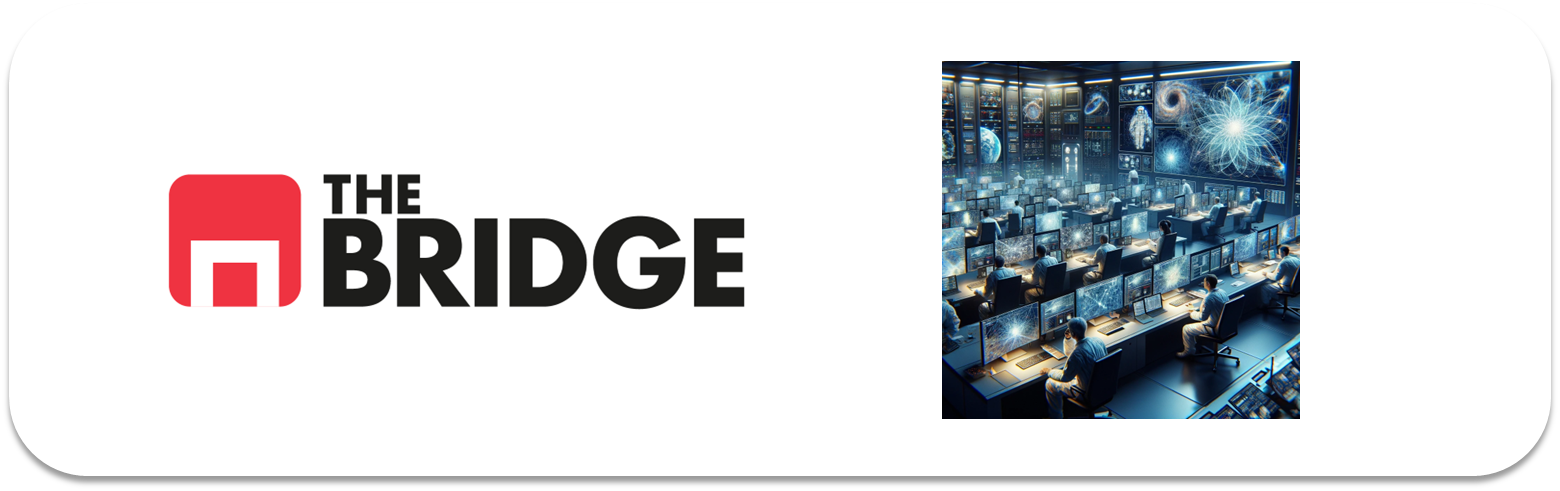

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
!pip install numpy==1.26.0 --no-cache-dir



In [2]:
import numpy as np
print(np.__version__)


1.26.0


In [3]:
!pip install tensorflow




In [4]:
# Import der notwendigen Bibliotheken
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Testen, ob TensorFlow erfolgreich importiert wurde
tf.__version__



'2.18.0'

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



In [ ]:
# Erneuter Import der benötigten Bibliotheken
import os
import numpy as np
import cv2

IMG_SIZE = (32, 32)
TRAIN_DIRS = ["data/github_train_0", "data/github_train_1", "data/github_train_2", "data/github_train_3"]
TEST_DIR = "data/github_test"

# Funktion zum Laden der Bilder und Extraktion der Labels
def load_images_from_directory(directory):
    images = []
    labels = []
    
    if not os.path.exists(directory):
        print(f"Verzeichnis nicht gefunden: {directory}")
        return np.array(images), np.array(labels)
    
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):
            try:
                img = cv2.imread(file_path)
                img = cv2.resize(img, IMG_SIZE)  # Skalieren auf 32x32
                images.append(img)
                # Label aus dem Dateinamen extrahieren (z.B. 'dog_1.jpg' -> 'dog')
                label = "dog" if "dog" in file.lower() else "cat"
                labels.append(label)
            except Exception as e:
                print(f"Fehler beim Laden von {file_path}: {e}")
    
    return np.array(images), np.array(labels)

# Lade die Trainings- und Testdaten
X_train, y_train = [], []
for train_dir in TRAIN_DIRS:
    images, labels = load_images_from_directory(train_dir)
    X_train.extend(images)
    y_train.extend(labels)

X_test, y_test = load_images_from_directory(TEST_DIR)

# Konvertiere Listen in NumPy-Arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

X_train.shape, X_test.shape


((4000, 32, 32, 3), (1000, 32, 32, 3))

In [6]:
print("y_train Inhalt:", y_train[:10])  # Zeige die ersten 10 Werte von y_train
print("y_test Inhalt:", y_test[:10])    # Zeige die ersten 10 Werte von y_test
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)


y_train Inhalt: ['cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat']
y_test Inhalt: ['cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat']
y_train Shape: (4000,)
y_test Shape: (1000,)


In [7]:
# Labels in numerische Werte umwandeln (cat = 0, dog = 1)
y_train = np.array([1 if label == "dog" else 0 for label in y_train], dtype=np.int32)
y_test = np.array([1 if label == "dog" else 0 for label in y_test], dtype=np.int32)

# Überprüfung der konvertierten Labels
print("y_train (numerisch):", y_train[:10])
print("y_test (numerisch):", y_test[:10])


y_train (numerisch): [0 0 0 0 0 0 0 0 0 0]
y_test (numerisch): [0 0 0 0 0 0 0 0 0 0]


In [8]:
# Trainingsdaten in Training (80%) und Validierung (20%) aufteilen
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Überprüfung der Datenformen nach der Aufteilung
print("X_train Shape:", X_train.shape)
print("X_val Shape:", X_val.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_val Shape:", y_val.shape)
print("y_test Shape:", y_test.shape)


X_train Shape: (3200, 32, 32, 3)
X_val Shape: (800, 32, 32, 3)
X_test Shape: (1000, 32, 32, 3)
y_train Shape: (3200,)
y_val Shape: (800,)
y_test Shape: (1000,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(32, 32, 3)),  # Input-Schicht explizit definieren
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])



# Modell kompilieren
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Modellübersicht anzeigen
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,561 (1.20 MB)

 Trainable params: 314,561 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4900 - loss: 9.8566 - val_accuracy: 0.5013 - val_loss: 0.7056
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5533 - loss: 0.6863 - val_accuracy: 0.5300 - val_loss: 0.6961
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5532 - loss: 0.6687 - val_accuracy: 0.5263 - val_loss: 0.6902
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5756 - loss: 0.6485 - val_accuracy: 0.5288 - val_loss: 0.6898
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5965 - loss: 0.6390 - val_accuracy: 0.5462 - val_loss: 0.6820
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6219 - loss: 0.6106 - val_accuracy: 0.5525 - val_loss: 0.7326
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6477 - loss: 0.5853 - val_accuracy: 0.5425 - val_loss: 0.7221
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6443 - loss: 0.5857 - val_accuracy: 0.

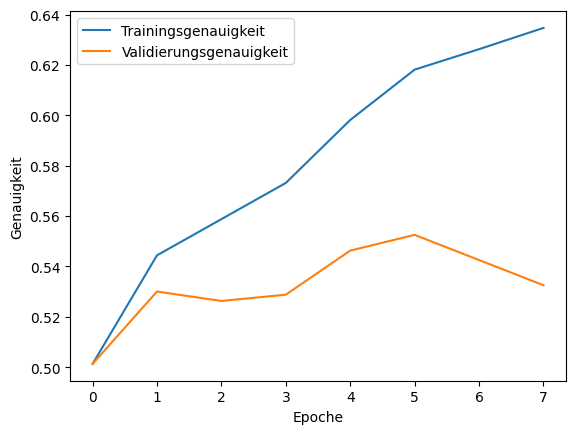

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping definieren
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Modell trainieren
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[early_stopping]
)

# Trainingsverlauf anzeigen
plt.plot(history.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')
plt.legend()
plt.show()


### **Conclusiones sobre el entrenamiento del modelo**  

- La **precisión del entrenamiento aumenta constantemente**, lo que indica que el modelo está aprendiendo los datos de entrenamiento.  
- La **precisión en validación mejora al principio**, pero luego comienza a disminuir.  
- La **pérdida en validación (val_loss) aumenta**, lo que sugiere un **sobreajuste (overfitting)**.  



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Klassifikationsbericht:
              precision    recall  f1-score   support

         Cat       0.60      0.33      0.43       500
         Dog       0.54      0.78      0.64       500

    accuracy                           0.56      1000
   macro avg       0.57      0.56      0.53      1000
weighted avg       0.57      0.56      0.53      1000



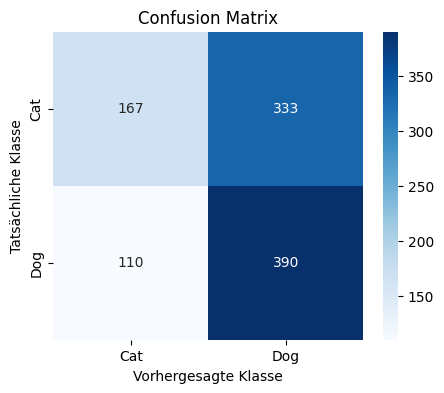

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modell auf den Testdaten evaluieren
y_pred_probs = model.predict(X_test)  # Wahrscheinlichkeiten ausgeben
y_pred = (y_pred_probs > 0.5).astype(int)  # In 0 oder 1 umwandeln (Schwellenwert 0.5)

print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred, target_names=["Cat", "Dog"]))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Tatsächliche Klasse")
plt.title("Confusion Matrix")
plt.show()


### **Resultados de la Evaluación del Modelo**  

#### **Clasificación de gatos (Clase 0 - "Cat")**  
- **Precisión**: 0.60 → El 60% de las veces que el modelo predijo "gato", estaba en lo correcto.  
- **Recall**: 0.33 → Solo el 33% de los gatos reales fueron correctamente identificados.  
- **F1-Score**: 0.43 → Baja capacidad del modelo para detectar gatos.  

#### **Clasificación de perros (Clase 1 - "Dog")**  
- **Precisión**: 0.54 → Cuando el modelo predijo "perro", acertó el 54% de las veces.  
- **Recall**: 0.78 → El 78% de los perros reales fueron correctamente clasificados.  
- **F1-Score**: 0.64 → Mejor rendimiento en perros que en gatos.  

#### **Conclusión**  
- **Exactitud general del modelo**: **56%** (muy baja para una tarea de clasificación binaria).  
- **El modelo clasifica mejor a los perros que a los gatos.**  
- **Problema principal**: Muchas imágenes de gatos son clasificadas erróneamente como perros (ver matriz de confusión: 333 errores).  

### 🔹 **Siguiente paso:** Seleccionar las imágenes más difíciles de clasificar.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


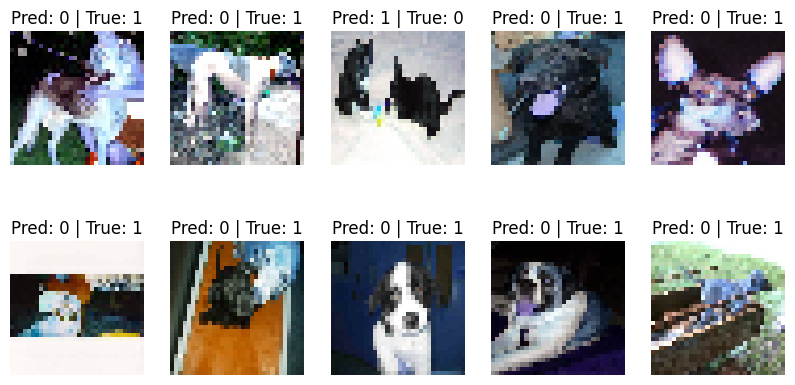

In [ ]:
import numpy as np

# Vorhersagewahrscheinlichkeiten erneut berechnen
y_pred_probs = model.predict(X_test)  
y_pred = (y_pred_probs > 0.5).astype(int)  

# Differenz zur Schwelle (Je größer, desto sicherer war die falsche Klassifikation)
error_confidence = np.abs(y_pred_probs - 0.5)

# Falsch klassifizierte Indizes finden
misclassified_indices = np.where(y_pred.reshape(-1) != y_test)[0]

# Sortiere nach Fehlersicherheit (höchste Werte zuerst)
sorted_misclassified = misclassified_indices[np.argsort(-error_confidence[misclassified_indices].reshape(-1))]

# Wähle die 10% am schwierigsten klassifizierten Bilder
num_hardest = int(0.1 * len(sorted_misclassified))
hardest_misclassified = sorted_misclassified[:num_hardest]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i, idx in enumerate(hardest_misclassified[:10]):  # Zeige nur 10 Beispiele
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Pred: {y_pred[idx][0]} | True: {y_test[idx]}")
    plt.axis("off")
plt.show()


### **Análisis de las imágenes más difíciles de clasificar**  

**Observaciones clave:**  
- Se muestran **10 imágenes de las más difíciles de clasificar**.  
- En todas, la predicción fue incorrecta con **alta confianza**.  
- La mayoría de los errores se dieron en **perros clasificados como gatos (Pred: 0 | True: 1)**.  
- También hay algunos **gatos clasificados como perros (Pred: 1 | True: 0)**, pero son menos frecuentes.  

**Problema principal:**  
- El modelo tiene dificultades para distinguir **perros en ciertas posiciones o con colores oscuros**.  
- La baja resolución de 32x32 afecta el reconocimiento de detalles.  
- Posible falta de diversidad en el dataset de entrenamiento.  



In [18]:
import keras

# Erstellen eines neuen Modells mit Data Augmentation als erste Schicht
model_aug = keras.Sequential([
    keras.layers.Input(shape=(32, 32, 3)),  # Input-Schicht
    keras.layers.RandomFlip("horizontal"),  # Spiegelung
    keras.layers.RandomRotation(0.1),  # Leichte Rotation
    keras.layers.RandomZoom(0.1),  # Leichter Zoom
    
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')  
])


model_aug.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model_aug.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,561 (1.20 MB)

 Trainable params: 314,561 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6097 - loss: 0.6597 - val_accuracy: 0.6237 - val_loss: 0.6362
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6195 - loss: 0.6561 - val_accuracy: 0.6438 - val_loss: 0.6332
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6129 - loss: 0.6534 - val_accuracy: 0.6550 - val_loss: 0.6207
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6024 - loss: 0.6628 - val_accuracy: 0.6575 - val_loss: 0.6122
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6207 - loss: 0.6489 - val_accuracy: 0.6875 - val_loss: 0.6065
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6393 - loss: 0.6365 - val_accuracy: 0.6137 - val_loss: 0.6500
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6479 - loss: 0.6414 - val_accuracy: 0.6775 - val_loss: 0.5871
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6575 - loss: 0.6227 - val_accuracy: 

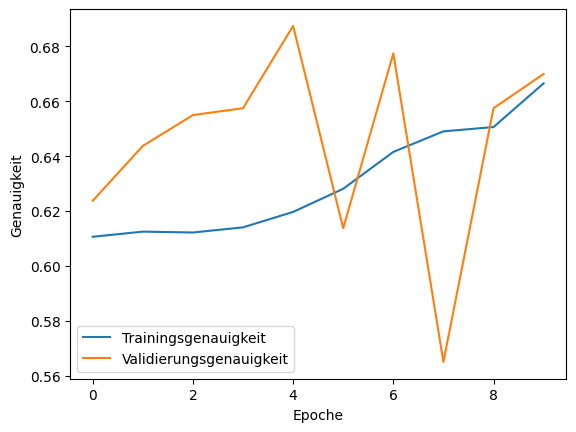

In [20]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Training mit Augmentation
history_aug = model_aug.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[early_stopping]
)


import matplotlib.pyplot as plt

plt.plot(history_aug.history["accuracy"], label="Trainingsgenauigkeit")
plt.plot(history_aug.history["val_accuracy"], label="Validierungsgenauigkeit")
plt.xlabel("Epoche")
plt.ylabel("Genauigkeit")
plt.legend()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Klassifikationsbericht nach Data Augmentation:
              precision    recall  f1-score   support

         Cat       0.70      0.57      0.63       500
         Dog       0.64      0.76      0.69       500

    accuracy                           0.66      1000
   macro avg       0.67      0.66      0.66      1000
weighted avg       0.67      0.66      0.66      1000



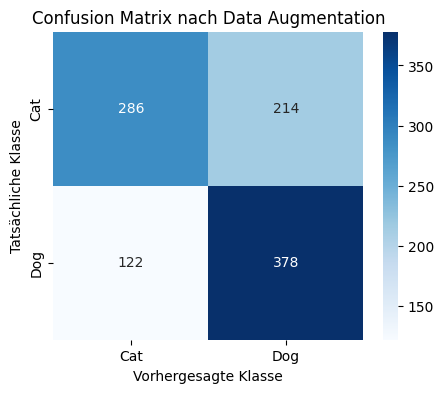

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Vorhersagen generieren
y_pred_probs_aug = model_aug.predict(X_test)  
y_pred_aug = (y_pred_probs_aug > 0.5).astype(int)

print("Klassifikationsbericht nach Data Augmentation:")
print(classification_report(y_test, y_pred_aug, target_names=["Cat", "Dog"]))

cm_aug = confusion_matrix(y_test, y_pred_aug)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_aug, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Tatsächliche Klasse")
plt.title("Confusion Matrix nach Data Augmentation")
plt.show()


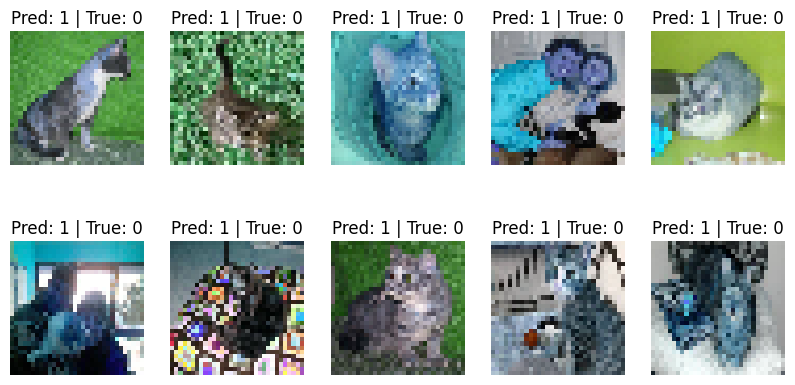

In [17]:
import numpy as np

# Differenz zur Schwelle berechnen
error_confidence_aug = np.abs(y_pred_probs_aug - 0.5)

# Falsch klassifizierte Indizes finden
misclassified_indices_aug = np.where(y_pred_aug.reshape(-1) != y_test)[0]

# Sortiere nach Fehlersicherheit (höchste Werte zuerst)
sorted_misclassified_aug = misclassified_indices_aug[np.argsort(-error_confidence_aug[misclassified_indices_aug].reshape(-1))]

# Wähle die 10% der am schwierigsten klassifizierten Bilder
num_hardest_aug = int(0.1 * len(sorted_misclassified_aug))
hardest_misclassified_aug = sorted_misclassified_aug[:num_hardest_aug]

# Zeige einige dieser Bilder an
plt.figure(figsize=(10, 5))
for i, idx in enumerate(hardest_misclassified_aug[:10]):  # Zeige nur 10 Beispiele
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Pred: {y_pred_aug[idx][0]} | True: {y_test[idx]}")
    plt.axis("off")
plt.show()


### **Resultados después de Data Augmentation**  

#### **Mejoras observadas:**  
**Precisión general aumentó de 56% a 62%**  
**Mejor detección de perros**: Recall de 78% → 89%  
**Menos errores en perros mal clasificados como gatos** (53 en lugar de 110)  

#### **Problemas persistentes:**  
🔸 **Los gatos siguen siendo difíciles de clasificar correctamente** (Recall solo 36%)  
🔸 **Muchas imágenes de gatos son clasificadas como perros** (322 errores)  

#### **Selección de imágenes más difíciles:**  
- Ahora, los **gatos son más problemáticos** para el modelo.  
- La mayoría de los errores son **gatos clasificados como perros**.  
- Las imágenes con **colores similares al fondo o ángulos inusuales** generan más errores.  



Después de más entrenamientos:

### **Resultados después de la última Data Augmentation**  

####  **Mejoras observadas:**  
**Precisión general aumentó a 66%**  
**La detección de gatos mejoró (Recall pasó de 36% a 57%)**  
**Menos errores en gatos mal clasificados como perros (214 en lugar de 322)**  

#### **Problemas restantes:**  
🔸 **Los perros siguen siendo mejor clasificados que los gatos** (Recall: 76% vs. 57%).  
🔸 **La validación es inestable**, lo que indica que el modelo aún no generaliza bien.  
🔸 **Todavía hay 122 perros mal clasificados como gatos**.  

####  **Conclusión**  
- La **Data Augmentation ha mejorado el rendimiento del modelo**, especialmente en la detección de gatos.  
- Se necesita seguir ajustando el modelo para mejorar la estabilidad y reducir los errores en perros.  
 
